# Identification
Please indicate your name and parcours (e.g.: IMA, DIGIT, BIM, DAC, ..., Erasmus)

Student 1: Nesrine Naaman (DIGIT)

Student 2: Giang Le (DIGIT)

# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()


## Exercise 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [183]:
from scipy.signal import convolve2d
import numpy as np

Sx=np.array([[1,0,-1], [2,0,-2], [1,0,-1]])
Sy=[[1,2,1],[0,0,0],[-1,-2,-1]]

def SobelDetector(I, s):
    """ Array*double -> Array """
    Sx=[[1,0,-1], [2,0,-2], [1,0,-1]]
    Sy=[[1,2,1],[0,0,0],[-1,-2,-1]]
    Ix=convolve2d(I, Sx, mode="same")
    Iy=convolve2d(I, Sy, mode="same")
    G_or=np.int64(np.sqrt(Ix**2 + Iy**2))
    G = G_or.copy()
    for i in range(G.shape[0]):
        for j in range(G.shape[1]):
            if (G[i][j]>=s):
                G[i][j]=1
            else:
                G[i][j]=0
    return Ix, Iy, G_or, G

I=np.ones((3,3))
# print(I)
# print(Sx)
# print(convolve2d(I,Sx, mode="full"))
# print(convolve2d(I,Sy, mode="same"))
print(SobelDetector(I,2))
    
    


(array([[ 3.,  0., -3.],
       [ 4.,  0., -4.],
       [ 3.,  0., -3.]]), array([[ 3.,  4.,  3.],
       [ 0.,  0.,  0.],
       [-3., -4., -3.]]), array([[4, 4, 4],
       [4, 0, 4],
       [4, 4, 4]]), array([[1, 1, 1],
       [1, 0, 1],
       [1, 1, 1]]))


2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighbor row. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighbor row $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [184]:
def imagePad(I,h):
    d = h.shape[0]
    x = int((d-1)/2)
    n = I.shape[0]
    m = I.shape[1]
    newI = np.zeros((n+d-1,m+d-1))

    for i in range(n):
        for j in range(m):
            newI[i+x][j+x] = I[i][j]
    return newI

def LaplacianDetector(I, s):
    L=np.array([[0,  1, 0],
                [1, -4, 1],
                [0,  1, 0]])
    """ Array*double -> Array """
    I2=convolve2d(I, L, mode="same")
    I2=imagePad(I2, L)
    Zero_cross=np.zeros(I.shape)
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            submatrix=I2[i:i+3,j:j+3]
            ILmax=np.max(submatrix)
            ILmin=np.min(submatrix)
            if(ILmax>0 and ILmin<0 and (ILmax-ILmin)>s):
                Zero_cross[i][j]=1
    return Zero_cross            


3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

From the difference value between the image after sobel and the image after laplacian , we can tell that the two images are most similar with a threshold equals to 70 for the sobel image and a threshold equals to 95 for the laplacian image

51246.0


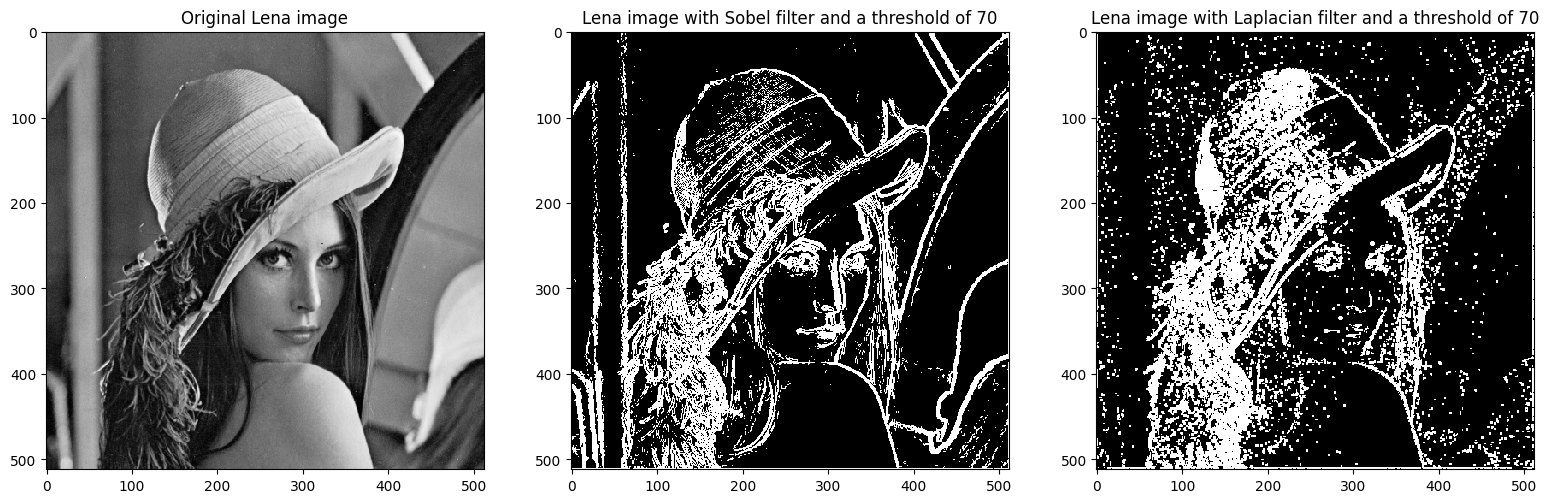

42724.0


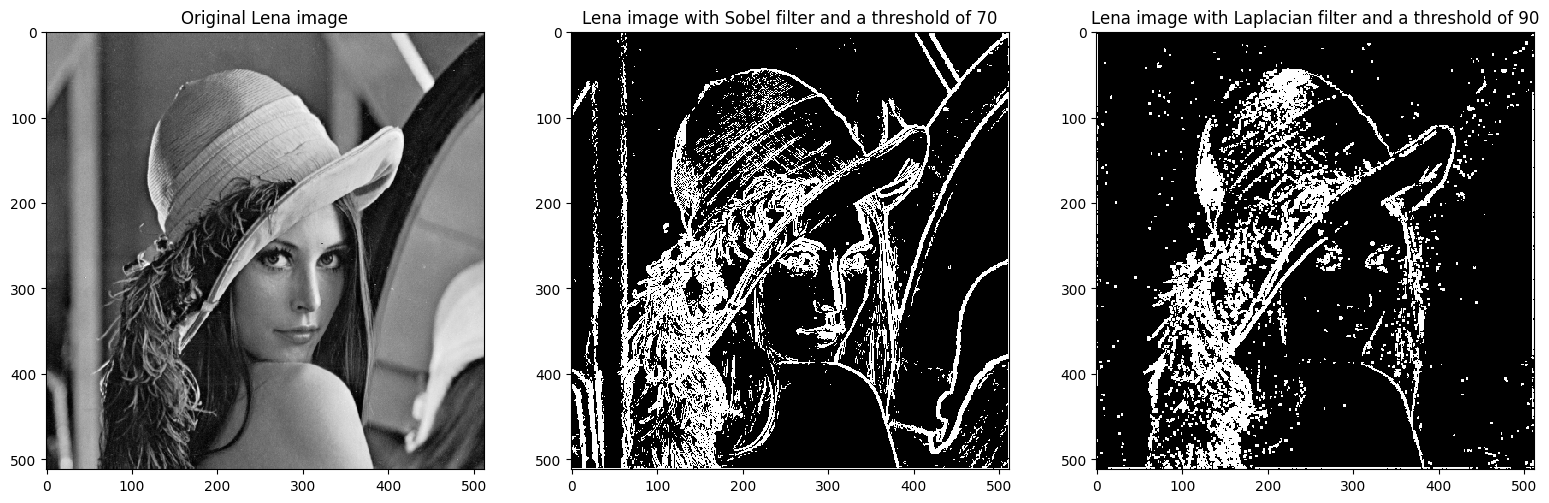

42301.0


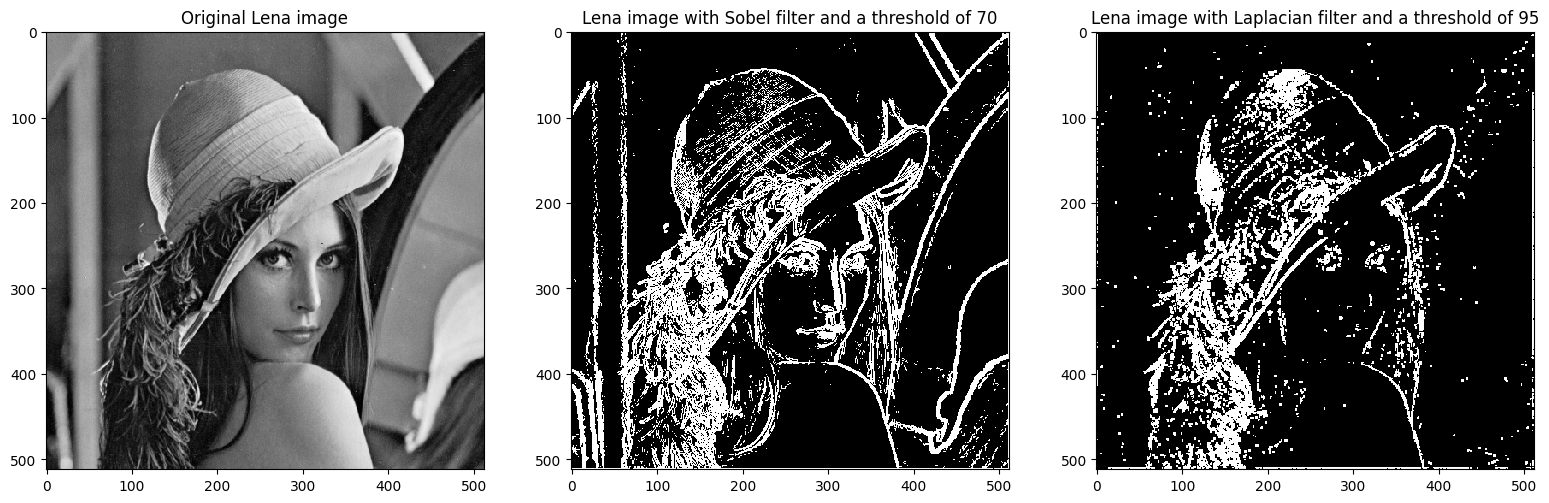

42468.0


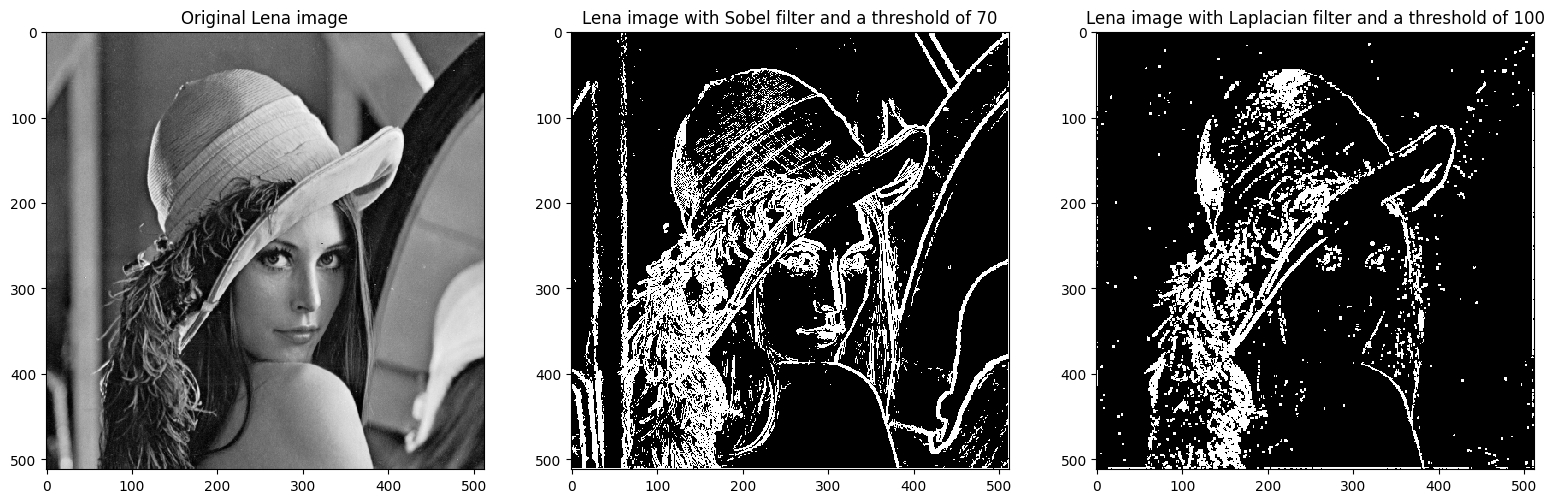

44680.0


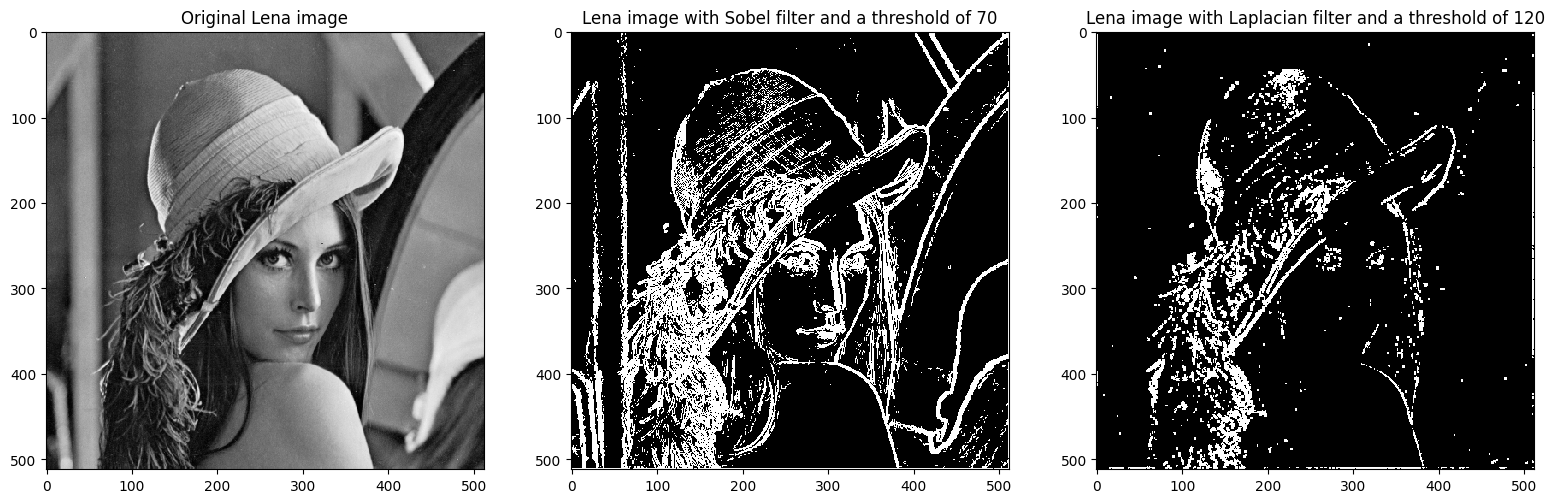

In [185]:
from PIL import Image
lena=np.array(Image.open('img/lena.png'))

Ix,Iy,Ig, Sobel=SobelDetector(lena, 70)
Lap=LaplacianDetector(lena, 70)
list = [lena, Sobel, Lap]
difference=np.abs(Sobel-Lap)
dif=np.sum(difference)
print(dif)
niceDisplay14(list, titres=["Original Lena image","Lena image with Sobel filter and a threshold of 70","Lena image with Laplacian filter and a threshold of 70"])

Ix,Iy,Ig,Sobel=SobelDetector(lena, 70)
Lap=LaplacianDetector(lena, 90)
list = [lena, Sobel, Lap]
difference=np.abs(Sobel-Lap)
dif=np.sum(difference)
print(dif)
niceDisplay14(list, titres=["Original Lena image","Lena image with Sobel filter and a threshold of 70","Lena image with Laplacian filter and a threshold of 90"])

Ix,Iy,Ig,Sobel=SobelDetector(lena, 70)
Lap=LaplacianDetector(lena, 95)
list = [lena, Sobel, Lap]
difference=np.abs(Sobel-Lap)
dif=np.sum(difference)
print(dif)
niceDisplay14(list, titres=["Original Lena image","Lena image with Sobel filter and a threshold of 70","Lena image with Laplacian filter and a threshold of 95"])

Ix,Iy,Ig, Sobel=SobelDetector(lena, 70)
Lap=LaplacianDetector(lena, 100)
list = [lena, Sobel, Lap]
difference=np.abs(Sobel-Lap)
dif=np.sum(difference)
print(dif)
niceDisplay14(list, titres=["Original Lena image","Lena image with Sobel filter and a threshold of 70","Lena image with Laplacian filter and a threshold of 100"])


Ix,Iy,Ig,Sobel=SobelDetector(lena, 70)
Lap=LaplacianDetector(lena, 120)
list = [lena, Sobel, Lap]
difference=np.abs(Sobel-Lap)
dif=np.sum(difference)
print(dif)
niceDisplay14(list, titres=["Original Lena image","Lena image with Sobel filter and a threshold of 70","Lena image with Laplacian filter and a threshold of 120"])


## Exercise 2: non maximum suppression

This exercise addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the notebook to see pixels value pointed by the mouse screen. **Warning**, this mode works only with jupyter notebook up to version 6).

[[4. 3. 3. ... 3. 3. 2.]
 [1. 0. 0. ... 0. 0. 4.]
 [1. 0. 0. ... 0. 0. 4.]
 ...
 [1. 0. 0. ... 0. 0. 4.]
 [1. 0. 0. ... 0. 0. 4.]
 [2. 3. 3. ... 3. 3. 4.]]


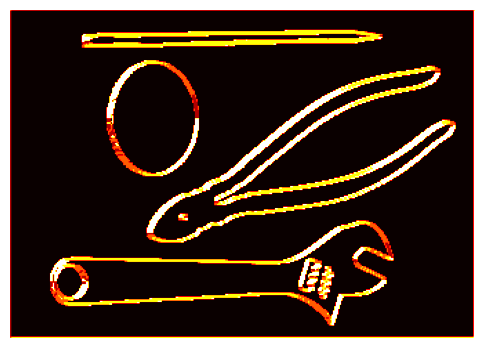

In [186]:
%matplotlib inline

# !pip3 install notebook=6 (if necessary)

#### your answer below

tools=np.array(Image.open("./img/tools.png"))
Ix, Iy, Ig_tools_or, Ig_tools=SobelDetector(tools, 90)
Ior_tools=orientation(Ix, Iy, Ig_tools_or)
print(Ior_tools)
imshow_hot(Ior_tools)


Explain the different values given to a pixel by `orientation()`:

Your answer: ...

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [187]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    G=np.zeros(Ior.shape)
    h=np.zeros((3,3))
    Ig=imagePad(Ig,h)
    for i in range(Ior.shape[0]):
        for j in range(Ior.shape[1]):
            if(Ior[i][j]==1):
                # compare with horizontal neighbors i,j+1 and i,j-1
                Ip=Ig[i+1][j+1]
                Ir=Ig[i+1][j]
                Iq=Ig[i+1][j+2]
                if(Ip>Ir and Ip>Iq):
                    G[i][j]=Ip
            elif(Ior[i][j]==2):
                # compare with diagonal neighbors i+1,j+1 and i-1,j-1
                Ip=Ig[i+1][j+1]
                Ir=Ig[i][j]
                Iq=Ig[i+2][j+2]
                if(Ip>Ir and Ip>Iq):
                    G[i][j]=Ip
            elif(Ior[i][j]==3):
                # compare with vertical neighbors i+1,j and i-1,j
                Ip=Ig[i+1][j+1]
                Ir=Ig[i][j+1]
                Iq=Ig[i+2][j+1]
                if(Ip>Ir and Ip>Iq):
                    G[i][j]=Ip
            elif(Ior[i][j]==4):
                # compare with i+1,j-1 and i-1,j+1
                Ip=Ig[i+1][j+1]
                Ir=Ig[i][j+2]
                Iq=Ig[i+2][j]
                if(Ip>Ir and Ip>Iq):
                    G[i][j]=Ip
    return G                

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


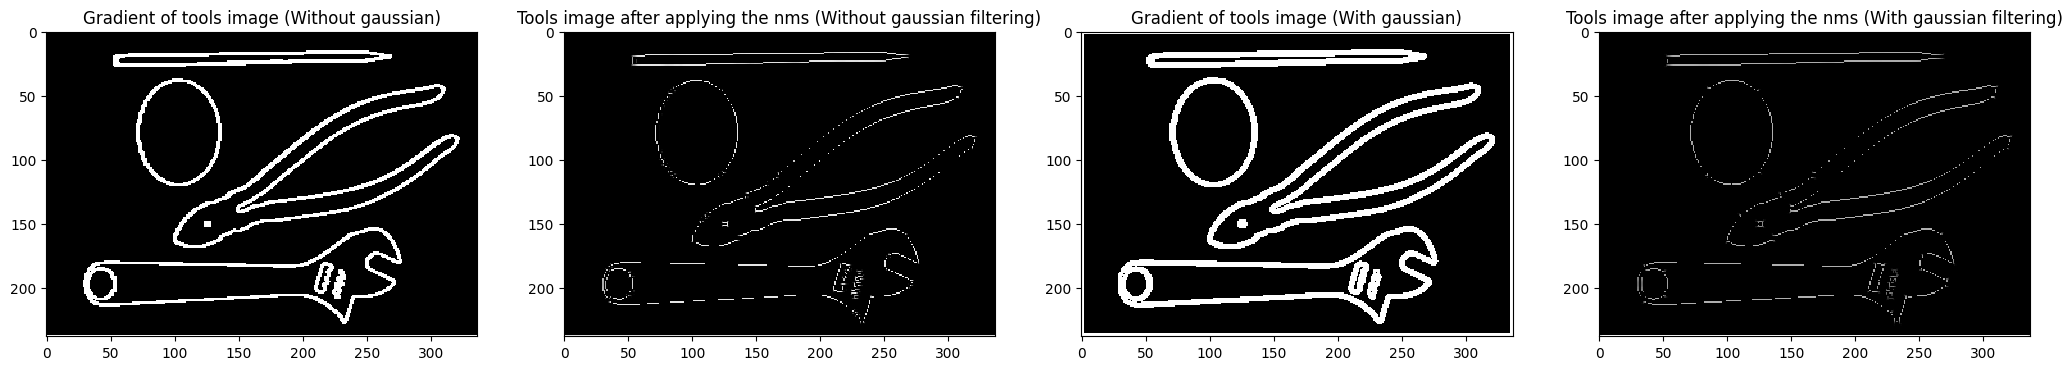

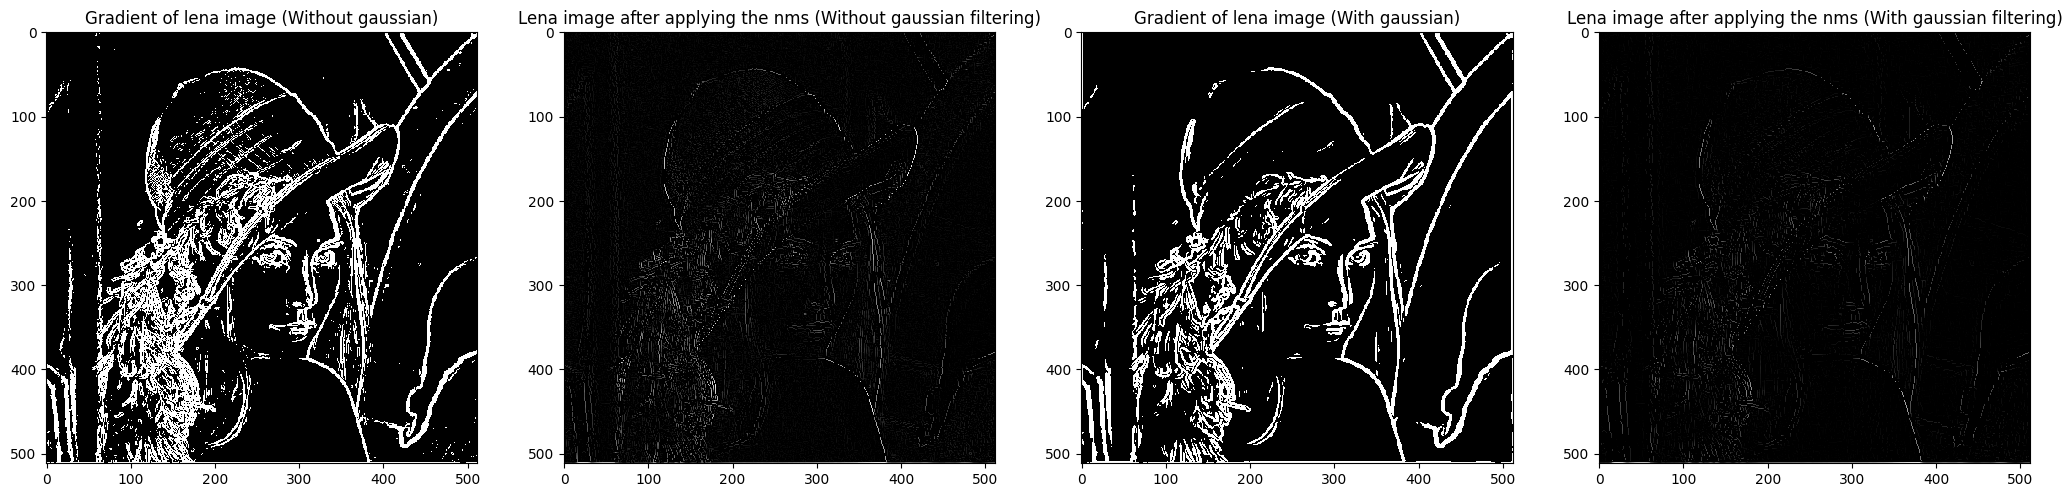

In [188]:
%matplotlib inline
### your answer below

# Without gaussian filter

# For tools.png
G_tools=nms(Ig_tools_or, Ior_tools)
#imshow(G_tools, title="Tools image after applying the nms function that suppresses the non-maxima (Without gaussian filtering)")

# For lena.png
Ix,Iy,Ig_lena_or, Ig_lena=SobelDetector(lena, 90)
Ior_lena=orientation(Ix, Iy, Ig_lena_or)
G_lena=nms(Ig_lena_or, Ior_lena)
#imshow(G_lena, title="Lena image after applying the nms function that suppresses the non-maxima (Without gaussian filtering)")

# With gaussian filter
sigma = 1
filter = gaussianKernel(sigma)

# For tools.png
tools_g = convolve2d(tools, filter, mode="same")
Ix, Iy,Ig_tools_g_or, Ig_tools_g=SobelDetector(tools_g, 90)
Ior_tools_g=orientation(Ix, Iy, Ig_tools_g_or)
G_tools_g=nms(Ig_tools_g_or, Ior_tools_g)
#imshow(G_tools_g, title="Tools image after applying the nms function that suppresses the non-maxima (With gaussian filtering)")

# For lena.png
lena_g = convolve2d(lena, filter, mode="same")
Ix, Iy,Ig_lena_g_or, Ig_lena_g=SobelDetector(lena_g, 90)
Ior_lena_g=orientation(Ix, Iy, Ig_lena_g_or)
G_lena_g = nms(Ig_lena_g_or, Ior_lena_g)
#imshow(G_lena_g, title="Lena image after applying the nms function that suppresses the non-maxima (With gaussian filtering)")

list = [Ig_tools, G_tools, Ig_tools_g,  G_tools_g]
niceDisplay14(list, titres=["Gradient of tools image (Without gaussian)",
                            "Tools image after applying the nms (Without gaussian filtering)",
                            "Gradient of tools image (With gaussian)",
                            "Tools image after applying the nms (With gaussian filtering)"])

list = [Ig_lena, G_lena, Ig_lena_g, G_lena_g]
niceDisplay14(list, titres=["Gradient of lena image (Without gaussian)",
                            "Lena image after applying the nms (Without gaussian filtering)",
                            "Gradient of lena image (With gaussian)",
                            "Lena image after applying the nms (With gaussian filtering)"])


4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

## Exercise 3:  effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

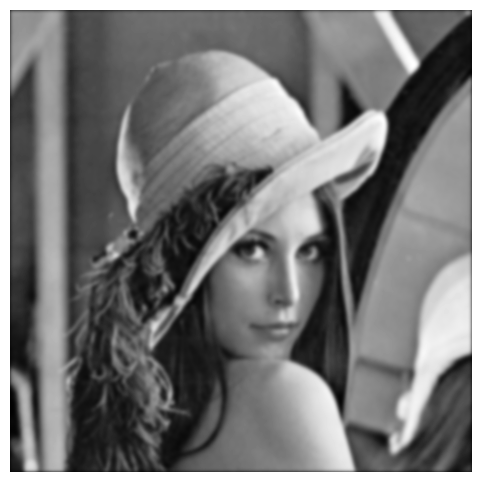

In [190]:
sigma = 2
filter = gaussianKernel(sigma)
lena_g = convolve2d(lena, filter, mode="same")
imshow(lena_g)

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

6423.0


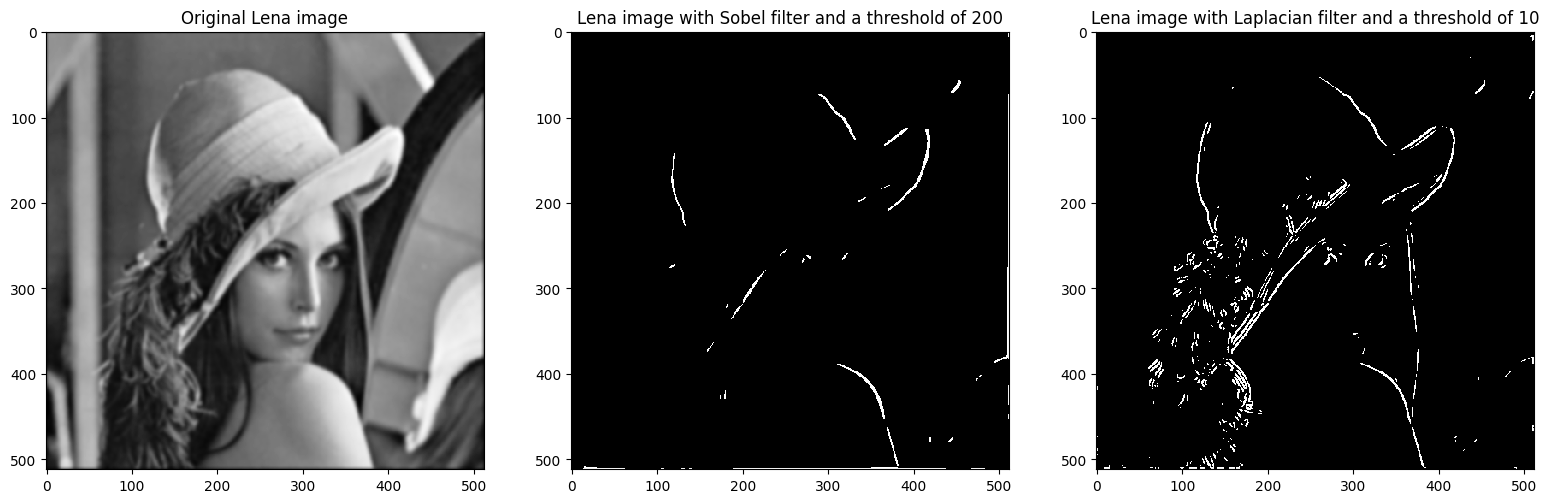

9016.0


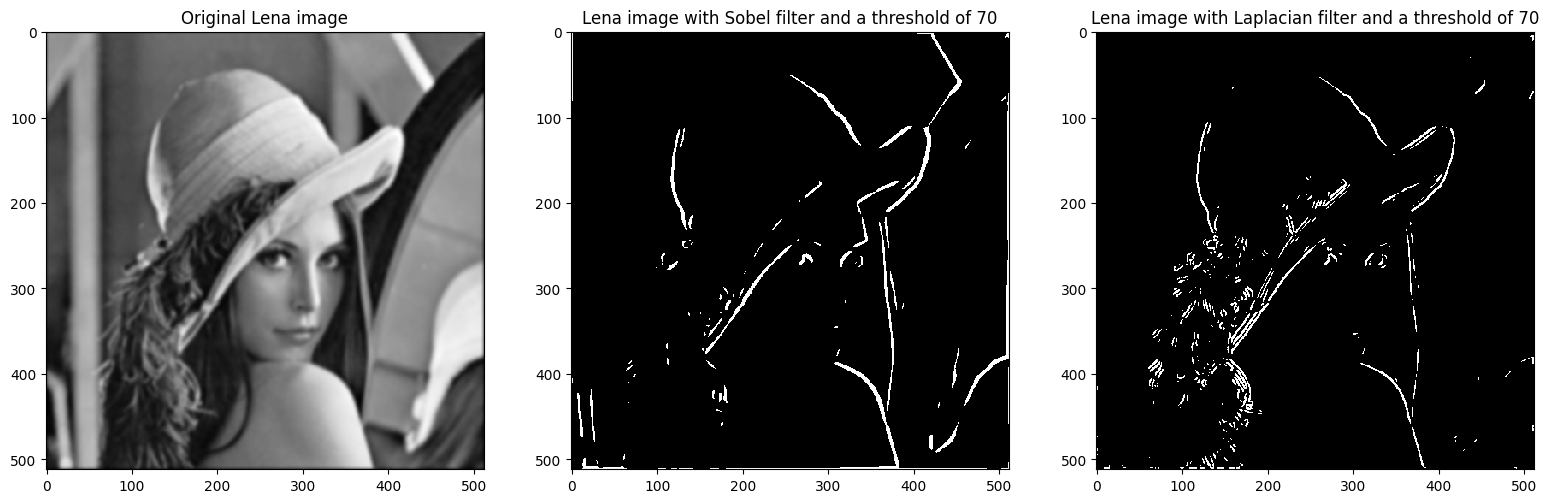

In [194]:
Ix,Iy,Ig, Sobel=SobelDetector(lena_g, 200)
Lap=LaplacianDetector(lena_g, 10)
list = [lena_g, Sobel, Lap]
difference=np.abs(Sobel-Lap)
dif=np.sum(difference)
print(dif)
niceDisplay14(list, titres=["Original Lena image","Lena image with Sobel filter and a threshold of 200","Lena image with Laplacian filter and a threshold of 10"])

Ix,Iy,Ig, Sobel=SobelDetector(lena_g, 140)
Lap=LaplacianDetector(lena_g, 10)
list = [lena_g, Sobel, Lap]
difference=np.abs(Sobel-Lap)
dif=np.sum(difference)
print(dif)
niceDisplay14(list, titres=["Original Lena image","Lena image with Sobel filter and a threshold of 70","Lena image with Laplacian filter and a threshold of 70"])


3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

46044774.0


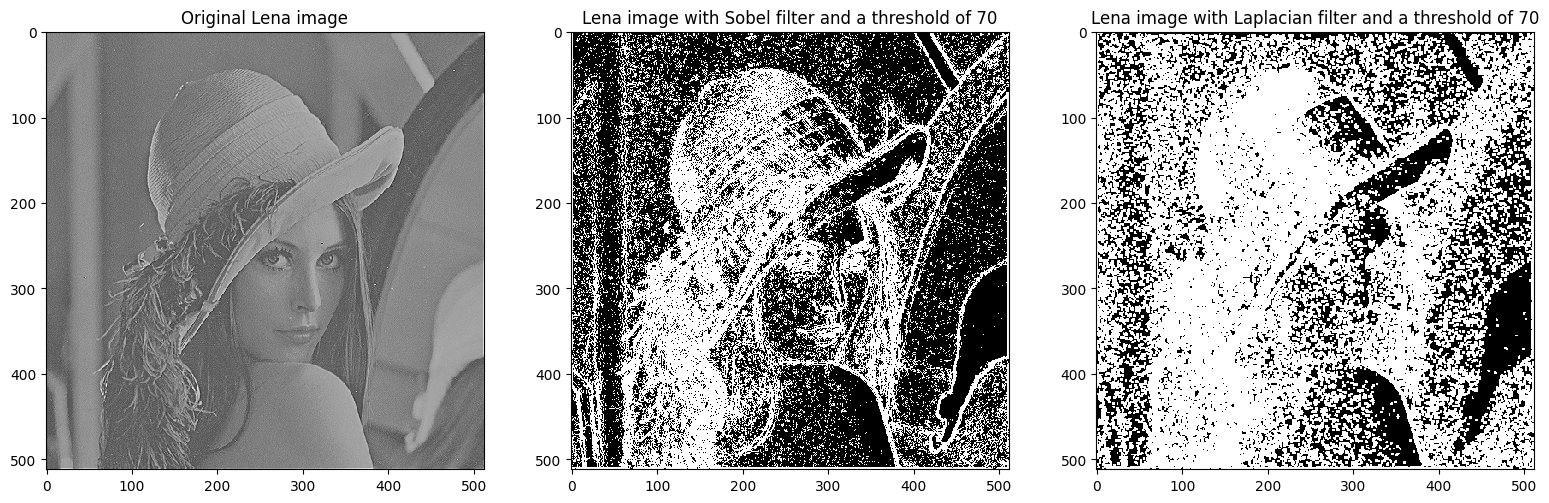

In [138]:
h = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
lena_enhanced = convolve2d(lena, h, mode="same")
Ix,Iy,Ig, Sobel=SobelDetector(lena_enhanced, 90)
Lap=LaplacianDetector(lena_enhanced, 240)
list = [lena_enhanced, Sobel, Lap]
difference=np.abs(Sobel-Lap)
dif=np.sum(difference)
print(dif)
niceDisplay14(list, titres=["Original Lena image","Lena image with Sobel filter and a threshold of 70","Lena image with Laplacian filter and a threshold of 70"])


5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

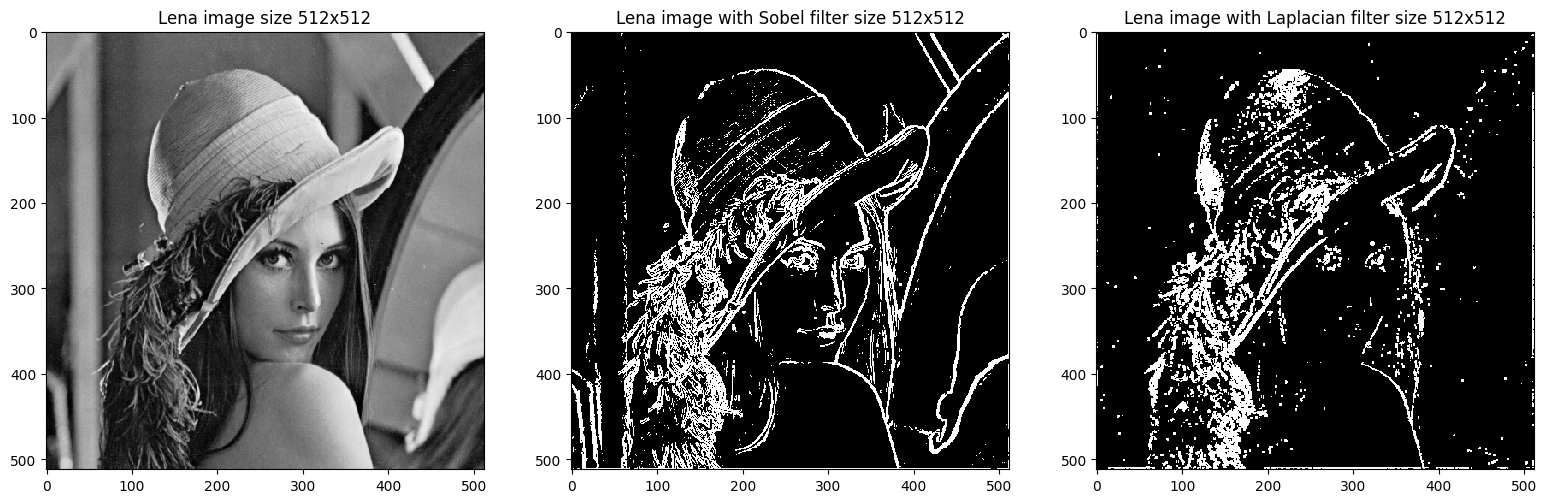

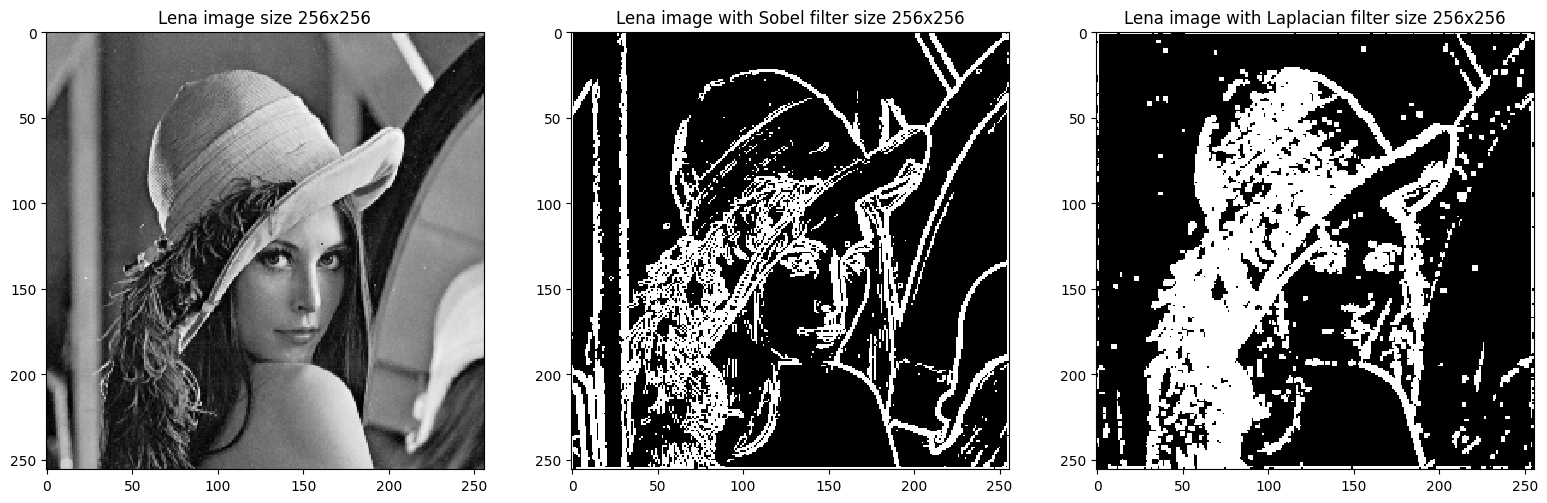

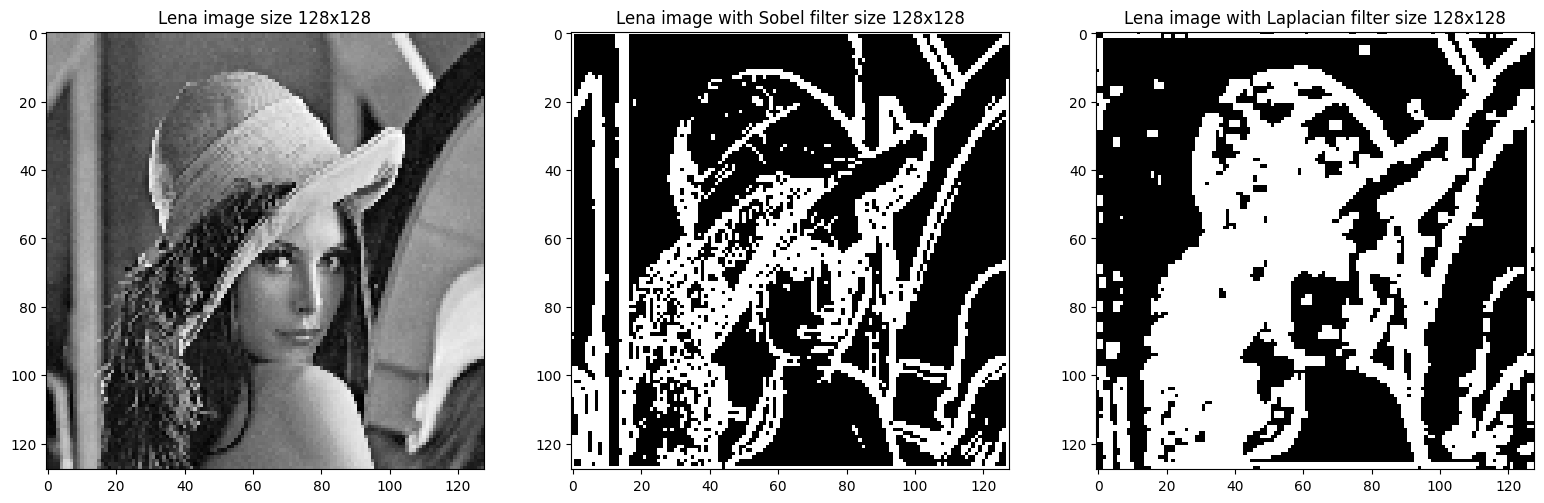

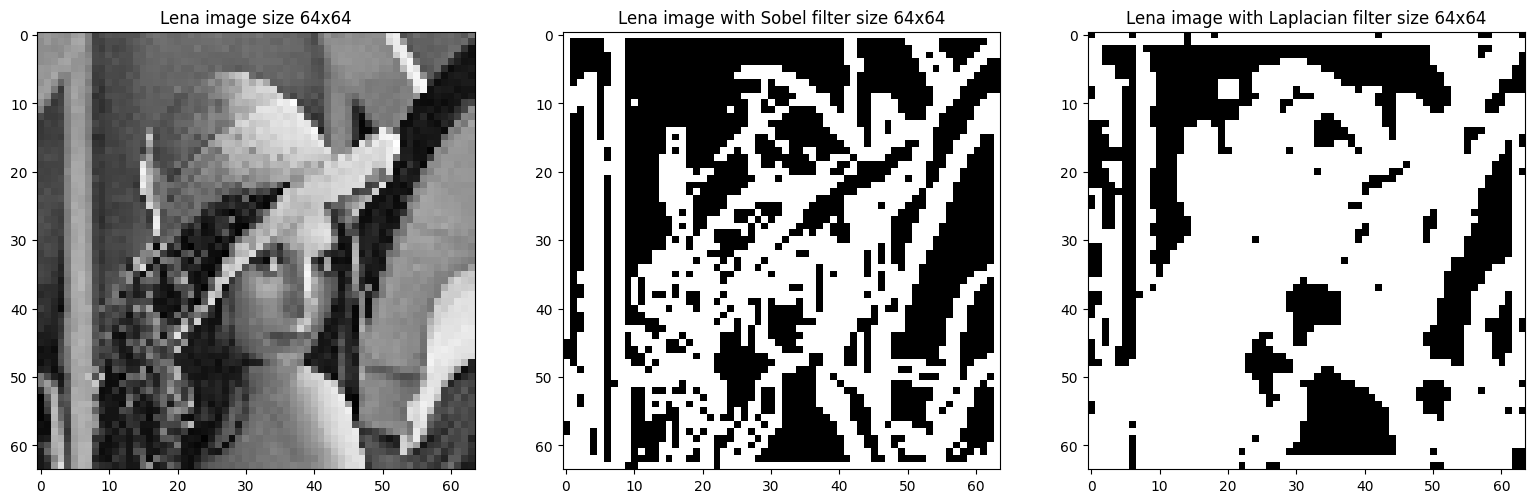

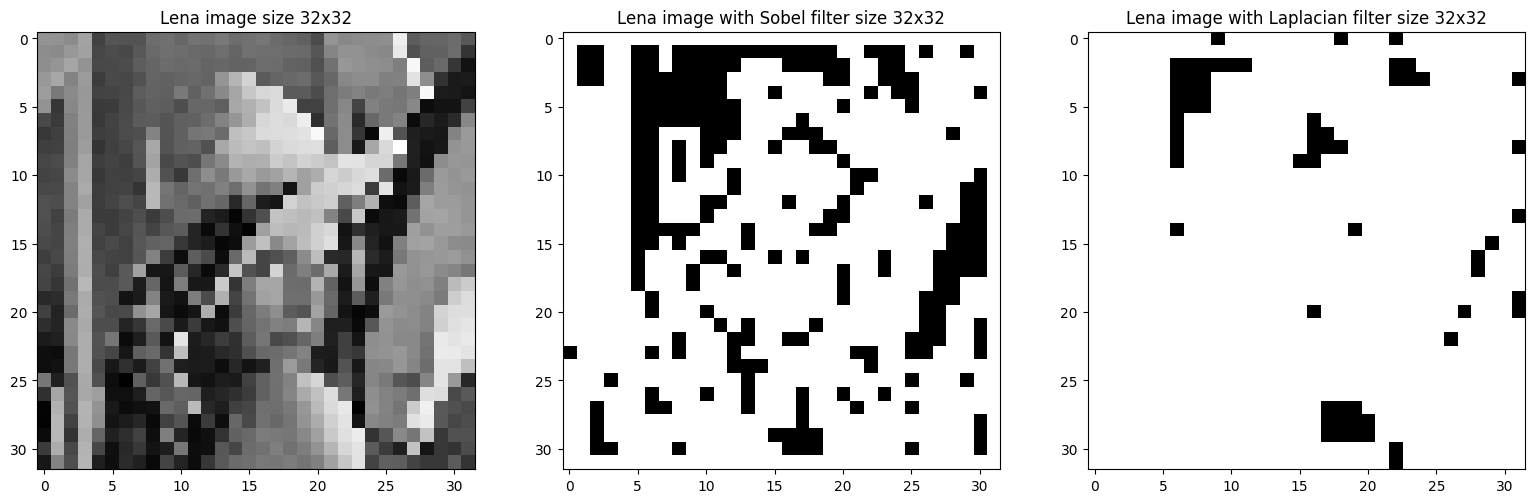

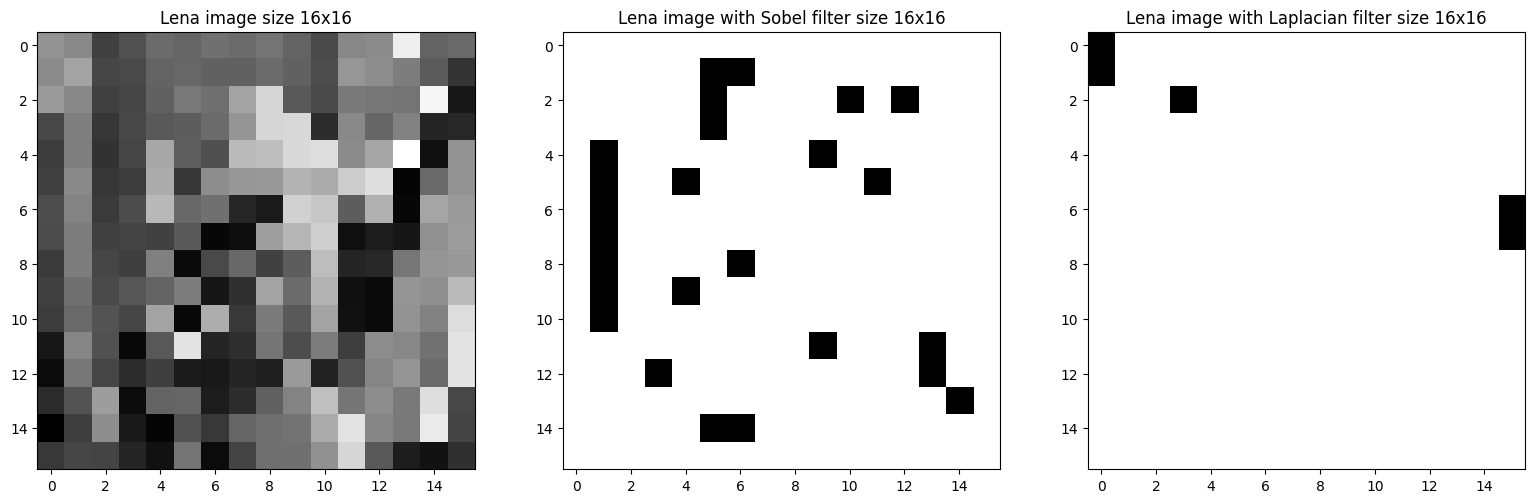

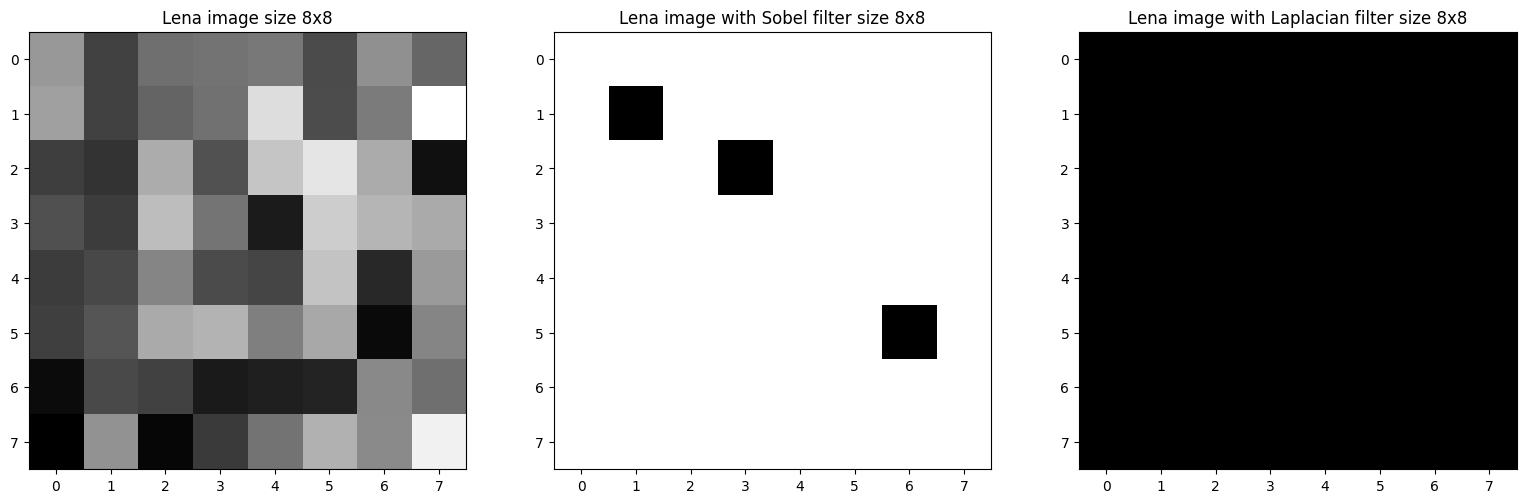

In [197]:
def subSample2(I):
    # Sample the signal by taking every T_s element
    return I[::2,::2]

sigma = 1/3
filter = gaussianKernel(sigma)
lena_g = convolve2d(lena, filter, mode="same")

while lena_g.shape[0]>=8:
    Ix, Iy, Ig_or, Sobel = SobelDetector(lena_g, 100)
    Lap=LaplacianDetector(lena_g, 100)
    list = [lena_g, Sobel, Lap]
    niceDisplay14(list, titres=["Lena image size "+ str(lena_g.shape[0]) +"x"+ str(lena_g.shape[1]),
                                "Lena image with Sobel filter size " + str(lena_g.shape[0]) +"x"+ str(lena_g.shape[1]),
                                "Lena image with Laplacian filter size "+ str(lena_g.shape[0]) +"x"+ str(lena_g.shape[1]) ])
    lena_g = subSample2(lena_g)


In [1]:
a = [[1,2,3],
     [4,5,6],
     [7,8,9]]

a[0][1]

2